<a href="https://colab.research.google.com/github/kalakhushi18/Deep-Learning/blob/main/HW2Part1_khushi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW2 Part 1

Due Date: 12.01.2025

Total Points: 25

The Transformer Architecture is today **the** dominating architecture for State-of-the-Art Machine Learning

In this homework we will understand and you will the first parts of the architecture

In [ ]:
import torch
import torch.nn as nn

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
torch.manual_seed(707)

Device: cuda:0


## The famous Transformer architecture

<img src= "https://drive.google.com/uc?id=1zEGMTmMqzwn25WXJHkf-jJ_C4A89fz6T" height= "500">

As we can see the whole transformer architecture consists of several block which we have to build and then assemble correctly. Luckily some blocks appear quite often and larger ensembles are then repeated N times. So that will save us a lot of work. Also FeedForward, Add&Norm, Linear and Softmax blocks are already known to us.

## Attention

The main part of the transformer architecture is the attention mechanism. The name makes the concept kind of self-explanatory, the art is to implement it in math and following that in code.

A bit on the history of the attention mechanism: It was first introduced in RNNs for language translation to give the model the ability to give focus(attention) on the time step outputs of the RNN corresponding to each input word. Therefor a mechanism was needed to go over a sequence of vetors(activations) of variable length and amass it to one single vector which then could be used then for prediction. (Later when we introduce multi-head attention it is not a single vector but multiple).

Okay that was quite a wording so let's see how it works with a simple example

In [ ]:
# Let's say we have three vector (three for simplicity)
# every vector has a dimensionality of 5 (I picked this for simplicity for the real transformer it is much higher )
embed_dim = 5
a = torch.rand((1,embed_dim))
b = torch.rand((1,embed_dim))
c = torch.rand((1,embed_dim))

In [ ]:
#Let's print vector a
a

tensor([[0.3238, 0.5000, 0.2395, 0.9894, 0.5413]])

We assume now that a, b and c are vector representations of words. And we want now to know how to combine these three vectors in a single vector which still has the size of (1, embed_dim) in this case (1,5)

The simplest way is to take an average over the (three) vectors. However, instead of weighting each vector equally, we want to weight them depending on their actual importance for our Machine Learning objective (e.g. translation). In other words, we want to dynamically decide on which inputs we want to pay more attention than to others.

$$
output \ vector = \alpha_1 × \vec{a} + \alpha_2 × \vec{b} +  \alpha_3 × \vec{c}
$$

The sum of the $α_s$ is one. If vector b is the most important one we could have a distribution of $α$ values like the following

$$
\alpha_1 = 0.05
$$
$$
\alpha_2 = 0.94
$$
$$
\alpha_3 = 0.01
$$

Hence we get an output vector which is the weighted sum of the three vectors but the most contribution comes from b so we can say the output vector paid mostly attention to vector b




In [ ]:
alpha_1, alpha_2, alpha_3 = 0.05, 0.94, 0.01

output = alpha_1 * a + alpha_2 * b + alpha_3 * c
output

tensor([[0.8115, 0.5399, 0.4092, 0.1301, 0.2400]])

In [ ]:
print(f"output: {output.tolist()}")
print(f"b     : {b.tolist()}")

output: [[0.8114653825759888, 0.5399146676063538, 0.40915048122406006, 0.1300857961177826, 0.2399982064962387]]
b     : [[0.8397395610809326, 0.5407127737998962, 0.41477662324905396, 0.07540476322174072, 0.2198513150215149]]


As we can see the output is mostly similiar to b. But there could be other cases where the attention should be only on a or divided between b and c.

So we need a way to compute the $α_s$ dynamically.



***Therefore three parts are needed***:

**Query**: The query is what we are looking for in the sequence. We can think of it like a question where the content of the question decides on what we want to pay attention to. The query is also represented as a mathematical vector.

**Keys**: For each element in the sequence, we have a key which is again a feature vector. This feature vector roughly describes what the element is "offering", or when if it might be important to this specific query(question). One can also think of them as the answers offered to the queries.

**Values**: For each input element, we also have a value vector. We already know about this because a,b,c from above are value vectors. These are the feature vectors on which we want to compute a dynamic average.

So the value vectors we have already and we will also see shortly how to compute the query and key vectors. The only remaining question is how to compute the $α_s$ from the query vector and the key vectors. Therefor we need a score function:

**Score function**: The score function takes the query and a key as input, and outputs the score(attention weight) of the query-key pair. Because the query and the key are just two normal vectors usually the dot product is computed between them to see how similiar they are. This is also done in the transformer but there are also other possibilities like a small MLP since we only need a function which maps two input vectors to a single scalar as the output.

So for the first part of the attention mechanism we need to compute the the dot product of a query vector with a key vector

Task 1 (5 points)

In [ ]:
# task 1
a_key = torch.rand((1, embed_dim))
b_key = torch.rand((1, embed_dim))
c_key = torch.rand((1, embed_dim))

a_query = torch.rand((1, embed_dim))


### YOUR CODE COMES HERE ###
# Implement the dot product between a_query and a_key
score_a_a = torch.matmul(a_query, a_key.T)

# # Now also for the other two combination: a_query and b_key, a_query and c_key
score_a_b = torch.matmul(a_query, b_key.T)
score_a_c = torch.matmul(a_query, c_key.T)

print(score_a_a)
print(score_a_b)
print(score_a_c)
### YOUR CODE ENDS HERE ###

tensor([[0.9752]])
tensor([[1.0290]])
tensor([[0.7270]])


Example how the output should look like:

tensor([[0.9752]])

tensor([[1.0290]])

tensor([[0.7270]])


So we have our scores now but the do not add up to one as we need them to become our α values. So what do we do? We take advantage of an old friend - the softmax function - and force them to sum to one. Wow, see like even the top researchers take often simple decisions which you already have learned about

Task 2 ( 5 points)

In [ ]:
# task 2
### YOUR CODE COMES HERE ###
## Implement a softmax over the scores
scores = torch.cat([score_a_a, score_a_b, score_a_c], dim=1)

softmax_scores = torch.nn.functional.softmax(scores, dim=1)

alpha_a_1, alpha_a_2, alpha_a_3 = softmax_scores[0, 0], softmax_scores[0, 1], softmax_scores[0, 2]

alpha_a_1.item(), alpha_a_2.item(), alpha_a_3.item()
### YOUR CODE ENDS HERE ###

(0.35268086194992065, 0.3721560835838318, 0.27516305446624756)

In [ ]:
alpha_a_1+ alpha_a_2 + alpha_a_3

tensor(1.)

Your results should look like this:

(0.35268089175224304, 0.3721560835838318, 0.27516305446624756)

As you see they now sum up to one

In [ ]:
# We can now again compute the output as at the beginning of the notebook
# But now we have not set the alphas manually but rather computed them

output_a = alpha_a_1 * a_key + alpha_a_2 * b_key + alpha_a_3 * c_key

print(output_a)

tensor([[0.4020, 0.5972, 0.4534, 0.5340, 0.5317]])


Task 3 (5 points)

In [ ]:
# Now there is not only a query_a, but also query_b and query_c
b_query = torch.rand((1, embed_dim))
c_query = torch.rand((1, embed_dim))

# Also create the corresponding attention weights for it and assemble them into a matrix

score_b_a = torch.matmul(b_query, a_key.T)
score_b_b = torch.matmul(b_query, b_key.T)
score_b_c = torch.matmul(b_query, c_key.T)

scores_b = torch.cat([score_b_a, score_b_b, score_b_c], dim=1)

softmax_scores_b = torch.nn.functional.softmax(scores_b, dim=1)

alpha_b_1, alpha_b_2, alpha_b_3 = softmax_scores_b[0, 0], softmax_scores_b[0, 1], softmax_scores_b[0, 2]

alpha_b_1.item(), alpha_b_2.item(), alpha_b_3.item()

(0.28099822998046875, 0.5144877433776855, 0.20451399683952332)

In [ ]:
score_c_a = torch.matmul(c_query, a_key.T)
score_c_b = torch.matmul(c_query, b_key.T)
score_c_c = torch.matmul(c_query, c_key.T)

scores_c = torch.cat([score_c_a, score_c_b, score_c_c], dim=1)

softmax_scores_c = torch.nn.functional.softmax(scores_c, dim=1)

alpha_c_1, alpha_c_2, alpha_c_3 = softmax_scores_c[0, 0], softmax_scores_c[0, 1], softmax_scores_c[0, 2]

alpha_c_1.item(), alpha_c_2.item(), alpha_c_3.item()

(0.3212473690509796, 0.4460607171058655, 0.2326919436454773)

In [ ]:
Q = torch.cat([a_query, b_query, c_query], dim= 0)
K = torch.cat ([a_key, b_key, c_key], dim = 0)

print("Shape of the Query matrix", Q.shape)
print("Shape of the Keys matrix", K.shape)

Shape of the Query matrix torch.Size([3, 5])
Shape of the Keys matrix torch.Size([3, 5])


In [ ]:
# if this code block throws an error you have wrong sizes for your matrices
assert Q.shape == torch.Size([3, 5])
assert K.shape == torch.Size([3, 5])

In [ ]:
# Compute the matrix dot product
scores = torch.matmul(Q, K.T)
print("Scores of the Main Q and K matrices\n", scores)

Scores of the Main Q and K matrices
 tensor([[0.9752, 1.0290, 0.7270],
        [1.0412, 1.6460, 0.7235],
        [1.0014, 1.3296, 0.6789]])


In [ ]:
assert scores.shape == torch.Size([3, 3])

In [ ]:
scores[0,:] #This is exactly the same scores as for our single scores computed for element a at the top of the notebook

tensor([0.9752, 1.0290, 0.7270])

In [ ]:
alphas = torch.nn.functional.softmax(scores, dim=1)

In [ ]:
print(alphas)
# These alphas are also similar to one calculated individually

tensor([[0.3527, 0.3722, 0.2752],
        [0.2810, 0.5145, 0.2045],
        [0.3212, 0.4461, 0.2327]])


In [ ]:
# Now we just have to assemble our values in a matrix and the we can apply our dynamic weighting
V = torch.cat((a,b,c), dim=0)

output = alphas @ V

In [ ]:
print(output)

tensor([[0.5896, 0.5604, 0.4393, 0.6449, 0.4453],
        [0.6441, 0.5546, 0.4297, 0.5159, 0.3935],
        [0.6164, 0.5564, 0.4315, 0.5780, 0.4179]])


Here the first row is our attention updated a vector, the second row is for the updated b vector and the third for the updated c vector. In general this mechanism work for arbitrary vector size and much more vectors than three. For example current architecture (April 2023) work on sequences of 2048 or 4096 embedded vectors which is also called the context window. The only restriction is the keys and the queries must share the same dimesions and the amount of single elements of queries, keys and values must be the same.

The complete attention mechanism could be summarized in the following formula which we basically implemented until this code cell in the notebook

$$
Attention(Q,K,V) = softmax(\frac{Q K^T}{\sqrt{d_k}})V
$$

One aspect we haven't implemented yet is the scaling factor of $\sqrt{d_k}$
. This scaling factor is crucial to maintain an appropriate variance of attention values after initialization. Remember that we intialize our layers with the intention of having equal variance throughout the model, and hence, Q and K also have a variance close to the other model layers. However, performing a dot product over two vectors with a variance 1 results in a scalar having
$d_k$-times higher variance.
If we do not scale down the variance back the softmax over the logits will already saturate for one random element and to 0 for all others. The gradients through the softmax will be close to zero so that the parameters can't be learned appropriately. This prevents extreme values in the softmax function and allows for stable gradients during training.

Task 4 (10 points)

In [ ]:
# We now assemble all the previous steps into one function which does the attention mechanism
def attention_mechanism(Q, K, V, mask=None):
    d_k = Q.size()[-1]  # Extract embedding dimension
    attn_logits = Q @ K.transpose(-2, -1)
    attn_logits = attn_logits / torch.sqrt(torch.tensor(d_k))
    #the mask here basically sets the attention logits close to - infinity so that for those attention weigthing of 0 result.
    # This is because we sometimes don't want that our model can pay attention to all values
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = torch.nn.functional.softmax(attn_logits, dim=-1)
    outputs = torch.matmul(attention, V)
    return outputs, attention

Explanation of function for scaling and dot product:

This function implements the scaled dot-product attention mechanism, which is a core part of the self-attention mechanism in Transformer models

Mask:Used to control which elements should not receive attention (e.g., padding or causal masking in decoding).

If a mask is provided, it is used to ignore certain positions in the attention computation.
masked_fill(mask == 0, -9e15) → This replaces the masked positions with a very large negative number (effectively -∞).
When softmax is applied, these positions become zero probabilities, ensuring no attention is given to them.

### Multi-Head attention

So what the heck is this now. Actually it is quite simple. It is mainly the attention mechanism copy&paste. The idea is the normally you have to focus on multiple words during translation (this can be generalized to any other task but the Transformer was invented for translation). When you one attention block you have to merge a lot of information together. So the solution is to use more than attention block which work completely seperately from each other.

In [ ]:
## for the implentation it is not actually to copy the attention mechanism x times for x heads. It more that you have a
## certain embedding_size e.g. 256 and if you have 8 heads than each head gets a 1/8 share of the embedding in this 256/8 = 32. If we would
## have to heads it would be 256/2 = 128.

#Let's implement Multi-Head Attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # All heads are stacked into a single matrix for efficiency i.e. all heads with their query, key and value values are concatenated
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim) # 3*embed_dim since we have to generate Q, K and V vectors which all have the size of embed_dim hence 3*embed_dim
        self.output_proj = nn.Linear(embed_dim, embed_dim)



    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size() #[Batch, SeqLen, InputDim] e.g. [32, 8, 256]

        qkv = self.qkv_proj(x) # [Batch, SeqLen, 3*Embed_dim]

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)# [Batch, SeqLen, Head, 3*HeadDim]
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, 3*HeadDim]
        q, k, v = qkv.chunk(3, dim=-1) # each [Batch, Head, SeqLen, 1*HeadDim]

        # Determine value outputs
        values, attention = attention_mechanism(q, k, v, mask=mask) # the attention_mechanism we implemented above  [Batch, Head, SeqLen, 1*HeadDim]
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, 1*HeadDim]
        values = values.reshape(batch_size, seq_length, self.embed_dim)  # [Batch, SeqLen, EmbedDim] -- EmbedDim = Head*HeadDim
        output = self.output_proj(values)  # [Batch, SeqLen, EmbedDim]

        if return_attention:
            return output, attention
        else:
            return output

Okay the code above is mainly code massaging but if you really want to understand every step than go through the code

Code Explanation


Multi-Head Attention allows the model to attend to different parts of the input simultaneously by splitting the embedding space into multiple heads. Instead of running multiple separate attention mechanisms, it splits the embedding into smaller parts for each head.

In the context of transformers and multi-head attention, sequence length refers to the number of tokens (words, subwords, or characters) in an input sequence

### Permutation equivariance

Permutation equivariance means that you can switch the inputs and still get the same output. This is a behaviour which definitively is not suitable when working with sentences because the word order matters.
The multi-head attention is actually looking at the input not as a sequence, but as a set of elements. This property makes the multi-head attention block and the Transformer architecture so powerful and widely applicable! But what if the order of the input is actually important as in sentences? The answer is to additionally encode the position in the input features, which we will take a closer look at later (topic Positional encodings below).

### Transformer Encoder

Now that we now how the multi-head attention block works we will integrate it into the Transformer architecture. Remember, originally, the Transformer model was developed for machine translation. Hence, it got an encoder-decoder structure where the encoder takes as input the whole sentence in the original language and generates an attention-based representation. More specifically each word(token) gets an attention-based representation. On the other hand, the decoder attends over this input sentence encoding and generates the translated sentence word by word. The word by word generation is also calle more technically autoregressive. While this structure is extremely useful for Sequence-to-Sequence tasks with the necessity of autoregressive decoding, we will focus here on the encoder part. Many advances in NLP have been made using pure encoder-based Transformer models (if interested, models include the BERT-family, the Vision Transformer, and more), and in our tutorial, we will also focus only the encoder part. If you have understood the encoder architecture, the decoder is a very small step to implement as well.

<img src= "https://drive.google.com/uc?id=1zEGMTmMqzwn25WXJHkf-jJ_C4A89fz6T" height= "500">

So we will implement the left part of this diagram which is the encoder part. Until now we have just implemented the orange Multi-Head Attention block. But basically these blocks are so easy to implement that we will do it directly in the Encoder class

In [ ]:
class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Input dimension
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer (orange block)
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP (blue block)
        self.feed_forward = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask) # compute the attention
        x = x + self.dropout(attn_out) # code skip layer connection with addition
        x = self.norm1(x) #apply layer norm

        # MLP part
        x_feed_forward = self.feed_forward(x) # compute feed forward network
        x = x + self.dropout(x_feed_forward) # code skip layer connection with addition
        x = self.norm2(x) #apply layer norm

        return x

Now we can implement the whole TransformerEncoder. Additionally we can give out the attention weights per layer

In [ ]:
class TransformerEncoder(nn.Module):

    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps

### Positional Encoding

We have discussed before that the Multi-Head Attention block is permutation-equivariant, and cannot distinguish whether an input comes before another one in the sequence or not. In tasks like language understanding, however, the position is important for interpreting the input words. We need to add the position information somehow. One surprisingly easy way which works is just to add a positional vector to each word embedding vector. We could learn a embedding for every possible position, but this would not generalize to a dynamical input sequence length. Hence, the better option is to use feature patterns that the network can identify from the features and potentially generalize to larger sequences. The specific pattern chosen by Vaswani et al. are sine and cosine functions of different frequencies, as follows


$$
PE_{pos,i} = \begin{cases}
\sin (\frac{pos}{10000^{i/d}}), & \text{if i mod 2 = 0 }  \\
\cos (\frac{pos}{10000^{(i-1)/d}}), & \text{else }
\end{cases}
$$

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

Let's plot them

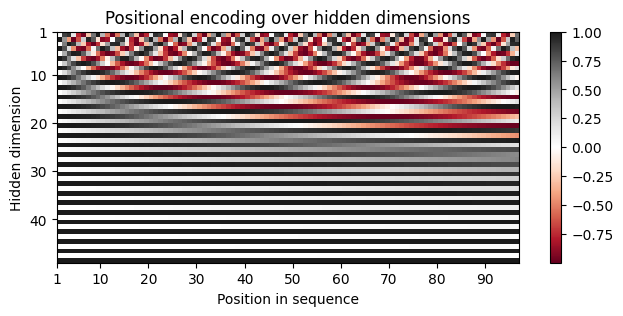

In [ ]:
import math
import matplotlib.pyplot as plt
encod_block = PositionalEncoding(d_model=48, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

This is the matrix of positional encodings. For example the column vector at 70 is added to the embedding vector of the 70th token.

In [ ]:
read_and_understood_everything_above = True      # (Just type True to get the 10 points)